In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [17]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from visual_behavior.data_access import loading as loading
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache


In [19]:
import visual_behavior.utilities as vbu
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.ophys.platform_paper_figures as ppf
import visual_behavior.visualization.ophys.summary_figures as sf
import visual_behavior.visualization.ophys.experiment_summary_figures as df

### load experiments_table 

In [20]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


In [21]:
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)


### get container and datasets

In [22]:
vip_containers = experiments_table[experiments_table.cell_type=='Vip Inhibitory'].ophys_container_id.unique()
sst_containers = experiments_table[experiments_table.cell_type=='Sst Inhibitory'].ophys_container_id.unique()

container_id = sst_containers[10]

ophys_experiment_id = experiments_table[experiments_table.ophys_container_id==container_id].index.values[0]

In [23]:
experiments_table[experiments_table.ophys_container_id==container_id]

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,area_binned_depth,layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
850517354,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,121.0,Sst-IRES-Cre,GCaMP6f,1,...,VISl_175,upper,20190411,False,-1.0,True,True,False,False,Familiar 0
853363751,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,127.0,Sst-IRES-Cre,GCaMP6f,4,...,VISl_175,upper,20190417,True,0.0,False,False,False,False,Novel 0
854759903,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,440631,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,129.0,Sst-IRES-Cre,GCaMP6f,6,...,VISl_175,upper,20190419,False,2.0,False,False,False,True,Novel 2


### Pete's selected experiments: 
* 425496_807753334_Slc17a7_VISp_175_OPHYS_3_images_A_1296
* 425496_808621034_Slc17a7_VISp_175_OPHYS_4_images_B_1780
* 431252_835006071_Slc17a7_VISp_375_OPHYS_4_images_B_1854
* 431252_835006071_Slc17a7_VISp_375_OPHYS_4_images_B_2111

### updated version - timeseries on different axes

In [24]:
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)

# ophys_experiment_id = experiments_table.index.values[0]
ophys_experiment_id = 807753334

dataset = loading.get_ophys_dataset(ophys_experiment_id)

trials = dataset.trials.copy()
start_times = trials[trials.stimulus_change].start_time.values
# start_time = start_times[10]
start_time = 1296

(286,)
(286,)


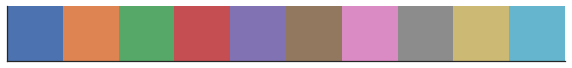

In [25]:
sns.palplot(sns.color_palette())

In [26]:
def addSpan(ax, amin, amax, color='k', alpha=0.3, axtype='x', zorder=1):
    """
    adds a vertical span to an axis
    """
    if axtype == 'x':
        ax.axvspan(amin, amax, facecolor=color, edgecolor='none', alpha=alpha, linewidth=0, zorder=zorder)
    if axtype == 'y':
        ax.axhspan(amin, amax, facecolor=color, edgecolor='none', alpha=alpha, linewidth=0, zorder=zorder)

        
def add_stim_color_span(dataset, ax, xlim=None, color=None, label_changes=False, label_omissions=False):
    """
    adds a vertical span for all stimulus presentations contained within xlim
    xlim is a time in seconds during a behavior session
    if label_changes is True, changes will be blue and all other flashes will be gray
    if label_changes is False, each flash will be colored according to image identity
    if label_omissions is True, a dotted line will be shown at the time of omission
    if a color is provided, all stimulus presentations will be that color
    """
    # set default alpha. If label_changes=True, alphas will be reset below. 
    alpha = 0.3
    # get stim table
    stim_table = dataset.stimulus_presentations.copy()
    # remove omissions because they dont get labeled
#     stim_table = stim_table[stim_table.omitted == False].copy()
    # get all images & assign colors (image colors wont be used if a color is provided or if label_changes is True)
    images = np.sort(stim_table[stim_table.omitted == False].image_name.unique())
    image_colors = sns.color_palette("hls", len(images))
    # limit to time window if provided
    if xlim != None: 
        stim_table = stim_table[(stim_table.start_time >= xlim[0]) & (stim_table.stop_time <= xlim[1])]
    # loop through stimulus presentations and add a span with appropriate color
    for idx in stim_table.index:
        start_time = stim_table.loc[idx]['start_time']
        stop_time = stim_table.loc[idx]['stop_time']
        image_name = stim_table.loc[idx]['image_name']
        image_index = stim_table.loc[idx]['image_index']
        if image_name == 'omitted':
            if label_omissions:
                ax.axvline(x=start_time, ymin=0, ymax=1, linestyle='--', color=sns.color_palette()[9])
        else:
            if label_changes: 
                if stim_table.loc[idx]['is_change']: # if its a change, make it blue with higher alpha
                    image_color = sns.color_palette()[0]
                    alpha = 0.5
                else: # if its a non-change make it gray with low alpha
                    image_color = 'gray'
                    alpha = 0.25
            else: 
                if color == None:
                    image_color = image_colors[image_index]
                else: 
                    image_color = color
            addSpan(ax, start_time, stop_time, color=image_color, alpha=alpha)
    return ax

In [27]:
def plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20, 
                                     label_changes=True, label_omissions=True,
                                     save_dir=None, ax=None):
    """
    Plots licking behavior, rewards, running speed, and pupil area for a defined window of time.
    Each timeseries gets its own row. If label_changes=True, all flashes are gray, changes are blue. 
    If label_changes=False, unique colors are given to each image.
    If label_omissions=True, a dotted line will be plotted at the time of omissions.
    """

    if label_changes: 
        suffix = '_changes'
    else: 
        suffix = '_colors'

    xlim_seconds = [start_time-(duration_seconds/4.), start_time+duration_seconds*2]

    lick_timestamps = dataset.licks.timestamps.values
    licks = np.ones(len(lick_timestamps))
    licks[:] = -2

    reward_timestamps = dataset.rewards.timestamps.values
    rewards = np.zeros(len(reward_timestamps))
    rewards[:] = -4

    # get run speed trace and timestamps
    running_speed = dataset.running_speed.speed.values
    running_timestamps = dataset.running_speed.timestamps.values
    # limit running trace to window so yaxes scale properly
    start_ind = np.where(running_timestamps<xlim_seconds[0])[0][-1]
    stop_ind = np.where(running_timestamps>xlim_seconds[1])[0][0]
    running_speed = running_speed[start_ind:stop_ind]
    running_timestamps = running_timestamps[start_ind:stop_ind]

    # get pupil width trace and timestamps
    eye_tracking = dataset.eye_tracking.copy()
    pupil_diameter = eye_tracking.pupil_width.values
    pupil_diameter[eye_tracking.likely_blink==True] = np.nan
    pupil_timestamps = eye_tracking.timestamps.values
    # smooth pupil diameter 
    from scipy.signal import medfilt
    pupil_diameter = medfilt(pupil_diameter, kernel_size=5)
    # limit pupil trace to window so yaxes scale properly
    start_ind = np.where(pupil_timestamps<xlim_seconds[0])[0][-1]
    stop_ind = np.where(pupil_timestamps>xlim_seconds[1])[0][0]
    pupil_diameter = pupil_diameter[start_ind:stop_ind]
    pupil_timestamps = pupil_timestamps[start_ind:stop_ind]

    if ax is None:
        figsize = (15, 5)
        fig, ax = plt.subplots(4, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [1, 1, 3, 3]})
        ax = ax.ravel()

    colors = sns.color_palette()

    ax[0].plot(lick_timestamps, licks, '|', label='licks', color=colors[3], markersize=10)
    ax[0].set_yticklabels([])
    ax[0].set_ylabel('licks', rotation=0, horizontalalignment='right', verticalalignment='center')

    ax[1].plot(reward_timestamps, rewards, 'o', label='rewards', color=colors[8], markersize=10)
    ax[1].set_yticklabels([])
    ax[1].set_ylabel('rewards', rotation=0, horizontalalignment='right', verticalalignment='center')

    ax[2].plot(running_timestamps, running_speed, label='running_speed', color=colors[2], zorder=100)
    ax[2].set_ylabel('running\nspeed\n(cm/s)', rotation=0, horizontalalignment='right', verticalalignment='center')
    ax[2].set_ylim(ymin=-8)

    ax[3].plot(pupil_timestamps, pupil_diameter, label='pupil_diameter', color=colors[4], zorder=0)
    ax[3].set_ylabel('pupil\ndiameter\n(pixels)', rotation=0, horizontalalignment='right', verticalalignment='center')

    for i in range(4):
        ax[i] = add_stim_color_span(dataset, ax[i], xlim=xlim_seconds, label_changes=label_changes, label_omissions=label_omissions)
        ax[i].set_xlim(xlim_seconds)
        ax[i].tick_params(which='both', bottom=False, top=False, right=False, left=True,
                    labelbottom=False, labeltop=False, labelright=False, labelleft=True)

    # label bottom row of plot
    ax[i].set_xlabel('time in session (seconds)')
    ax[i].tick_params(which='both', bottom=True, top=False, right=False, left=True,
                    labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    # add title to top row
    metadata_string = utils.get_metadata_string(dataset.metadata)
    ax[0].set_title(metadata_string)

    plt.subplots_adjust(hspace=0)
    if save_dir:
        print('saving')
        folder = 'behavior_timeseries_stacked'
        utils.save_figure(fig, figsize, save_dir, folder, metadata_string + '_' + str(int(start_time))+'_'+suffix, 
                          formats=['.png', '.pdf'])
    return ax


### test

In [28]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots'

saving


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3B6AD3DA0>,
      dtype=object)

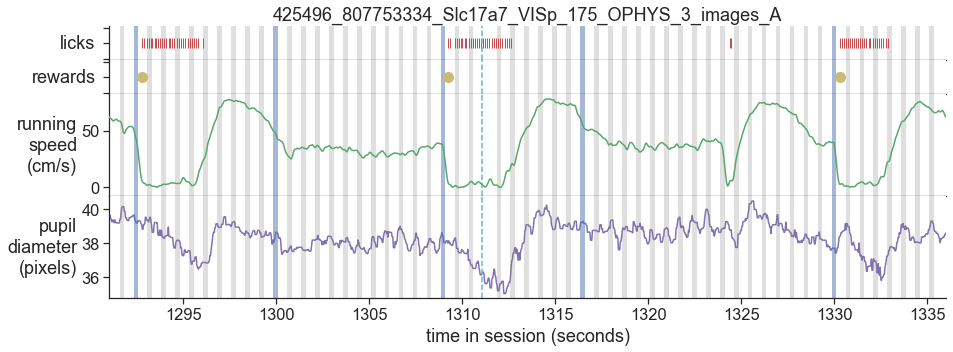

In [29]:
plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20, save_dir=save_dir, ax=None)

### plot and save for specific experiment 

### Pete's selected experiments: 
* 425496_807753334_Slc17a7_VISp_175_OPHYS_3_images_A_1296
* 425496_808621034_Slc17a7_VISp_175_OPHYS_4_images_B_1780
* 431252_835006071_Slc17a7_VISp_375_OPHYS_4_images_B_1854
* 431252_835006071_Slc17a7_VISp_375_OPHYS_4_images_B_2111

In [162]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots'

saving


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001236CFB1F98>,
      dtype=object)

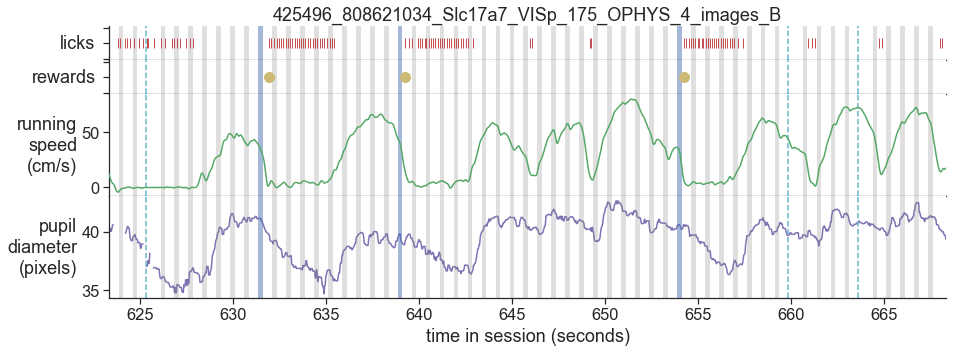

In [169]:
ophys_experiment_id = 808621034

dataset = loading.get_ophys_dataset(ophys_experiment_id)

trials = dataset.trials.copy()
start_times = trials[trials.stimulus_change].start_time.values
start_time = start_times[10]

plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20, save_dir=save_dir, ax=None)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000120E3EBADA0>,
      dtype=object)

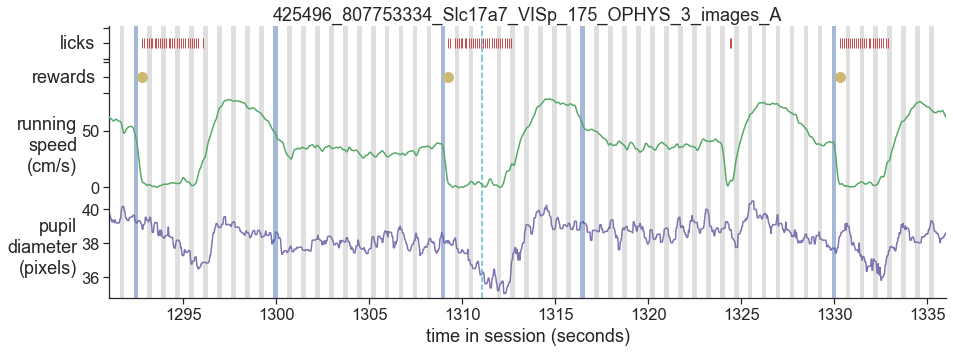

In [179]:
ppf.plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20, save_dir=save_dir, ax=None)

### plot for multiple change times

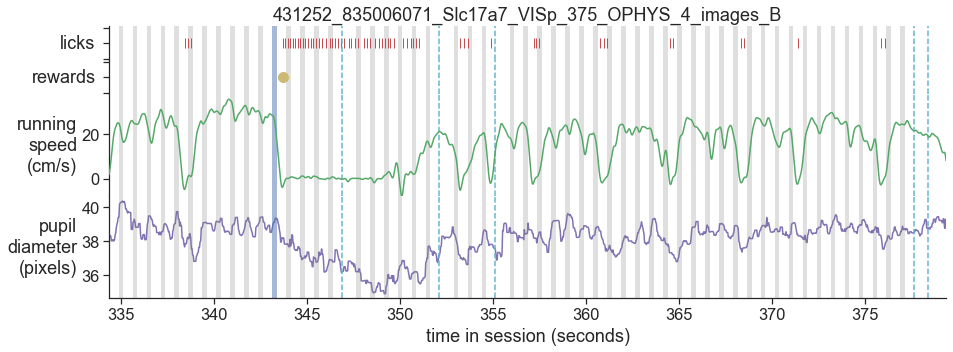

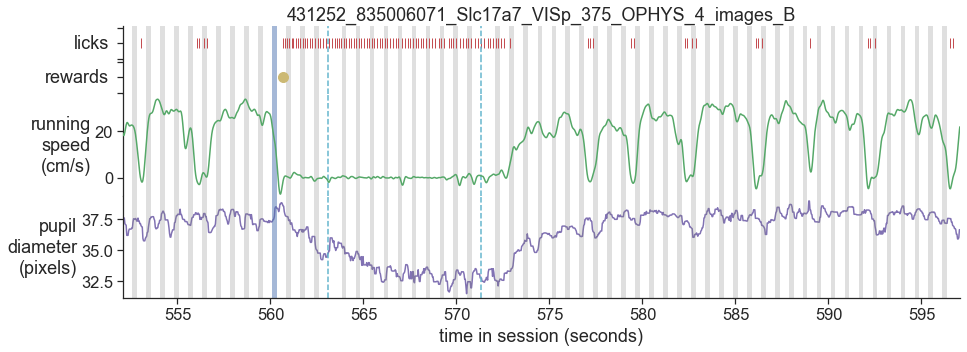

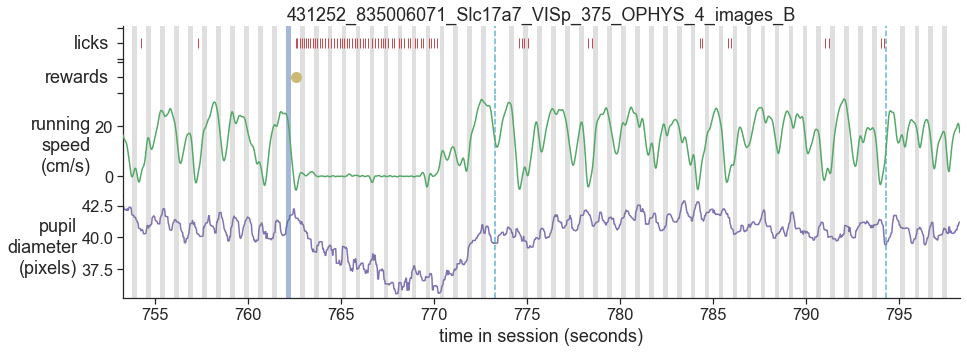

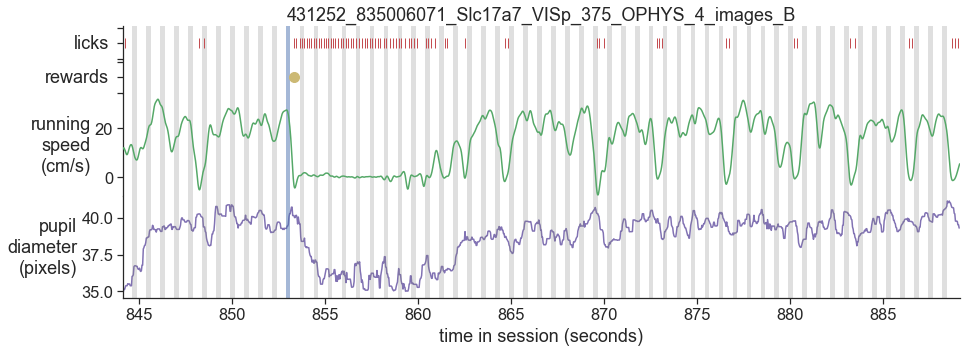

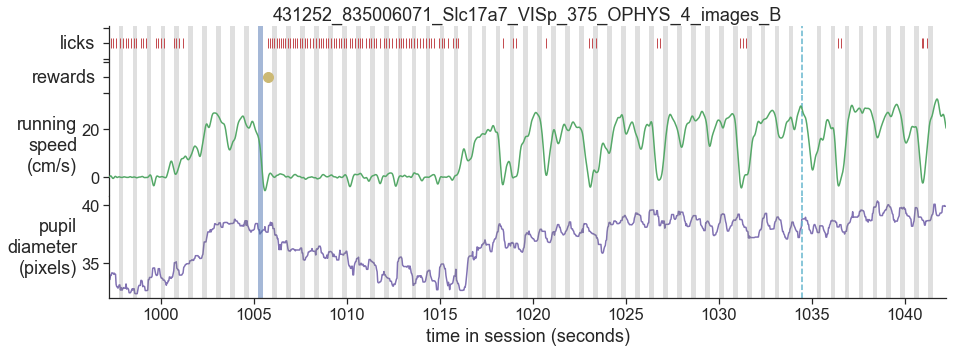

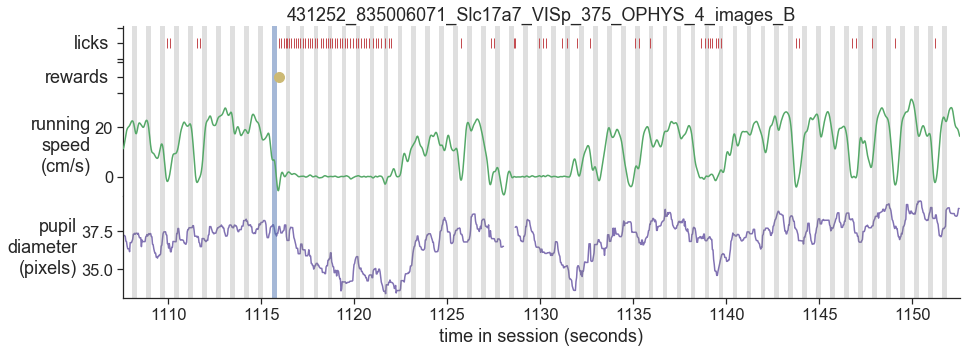

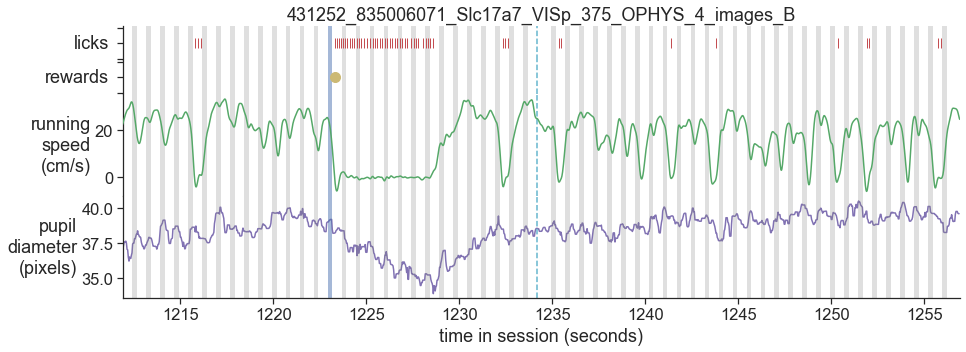

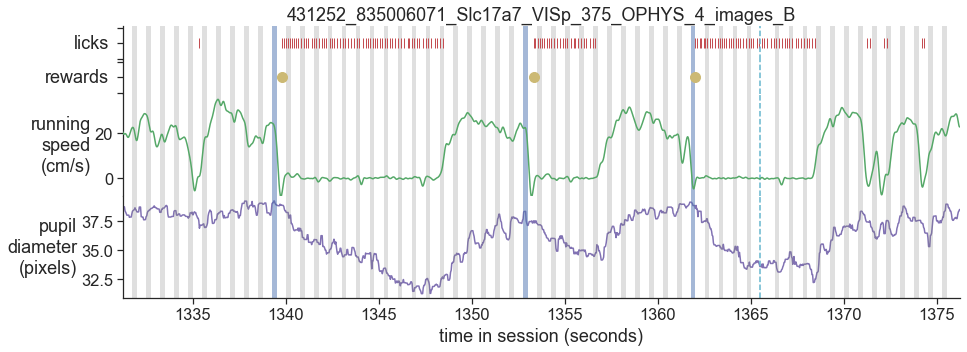

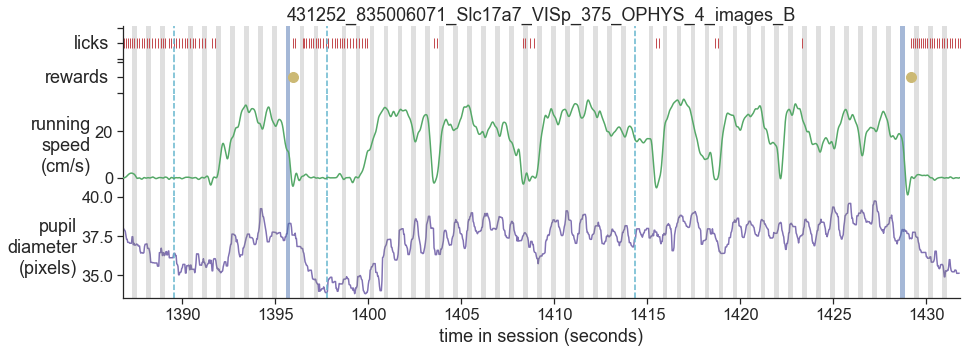

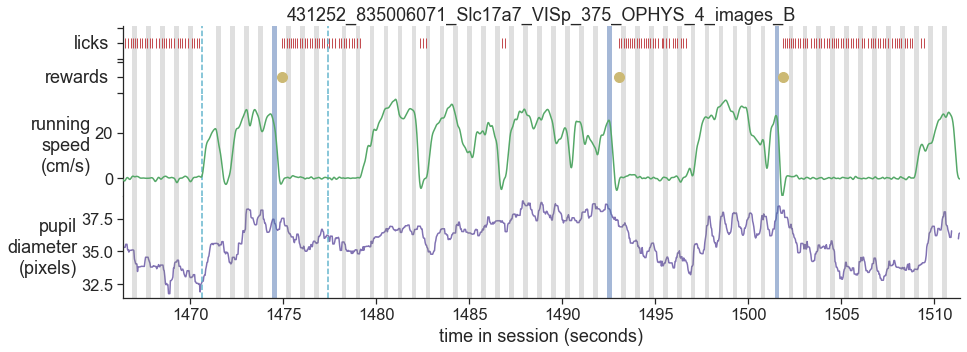

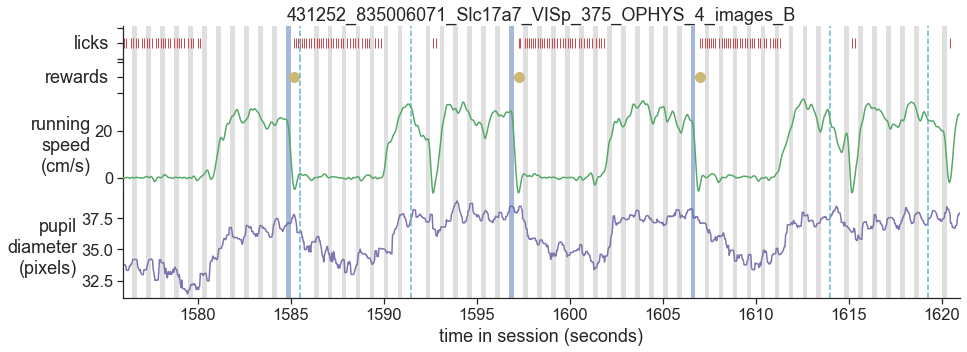

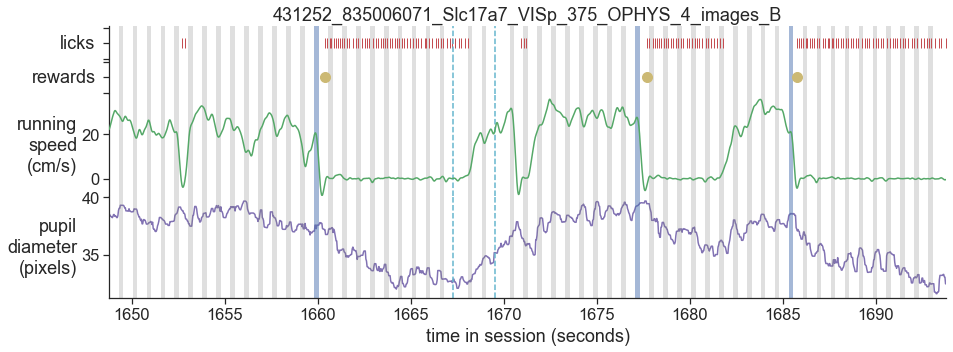

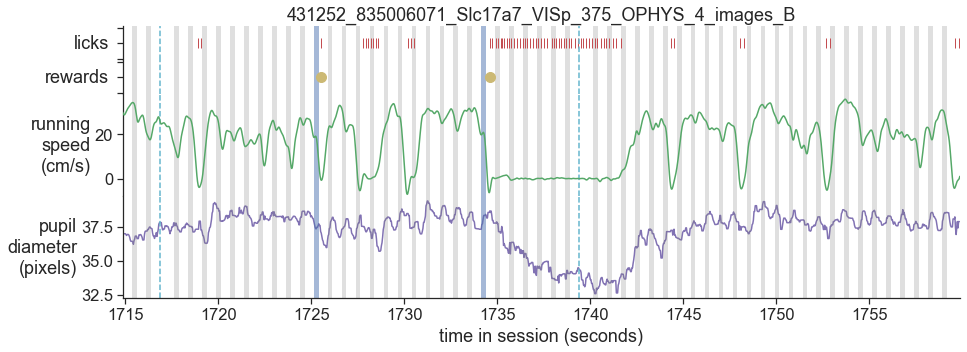

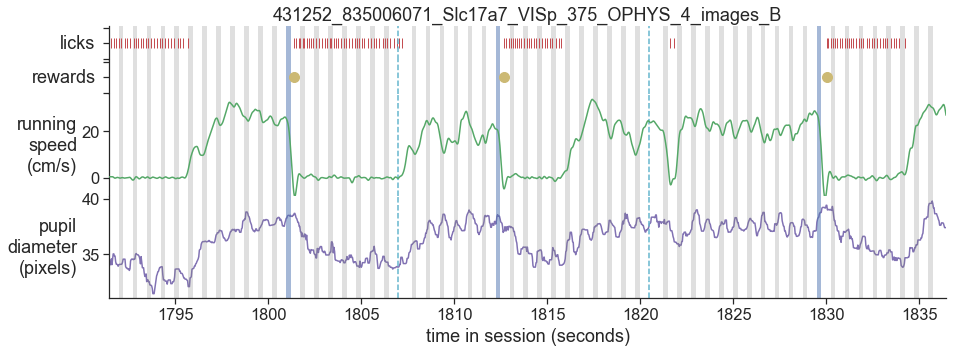

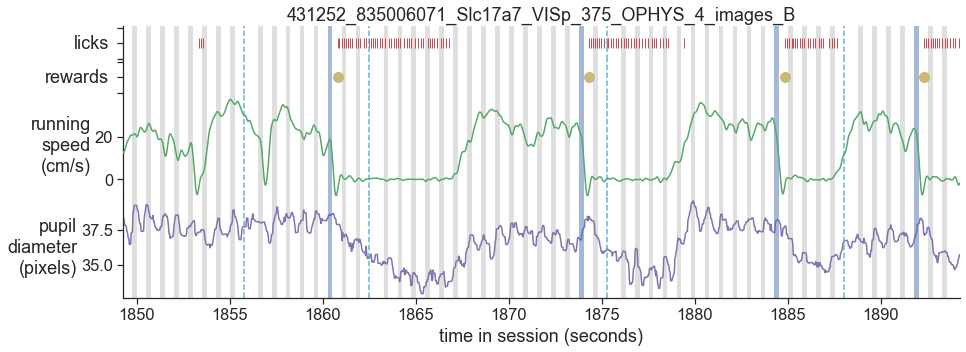

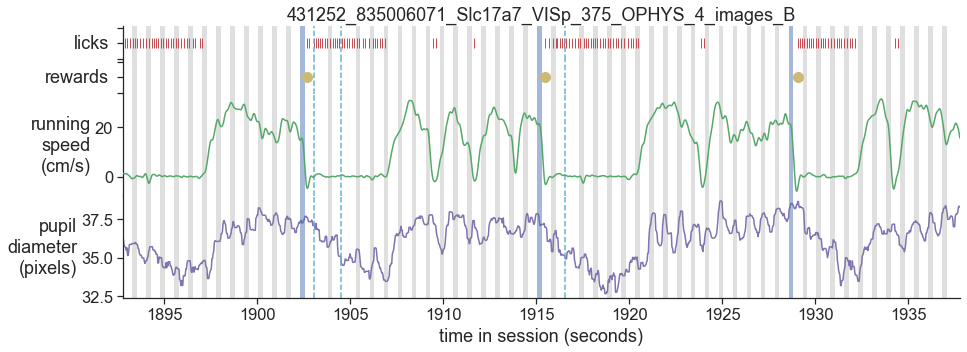

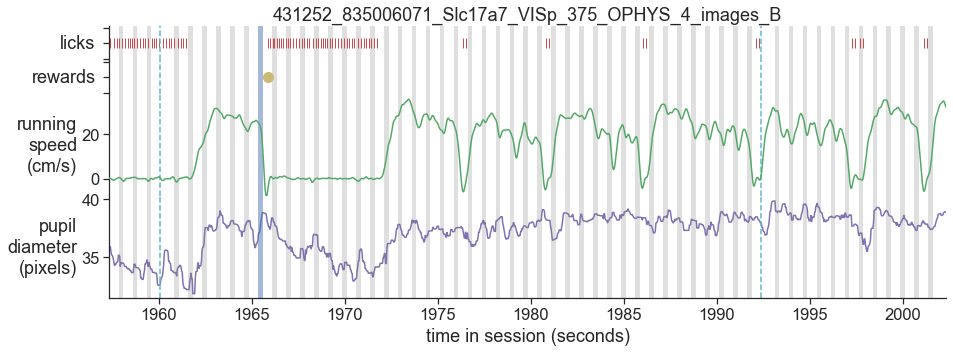

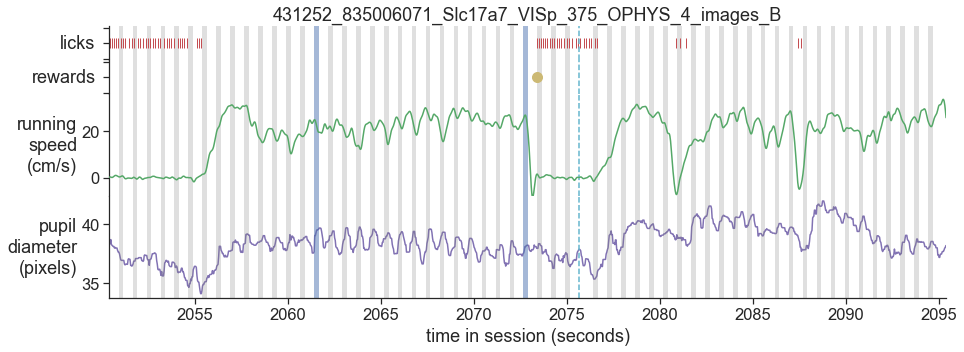

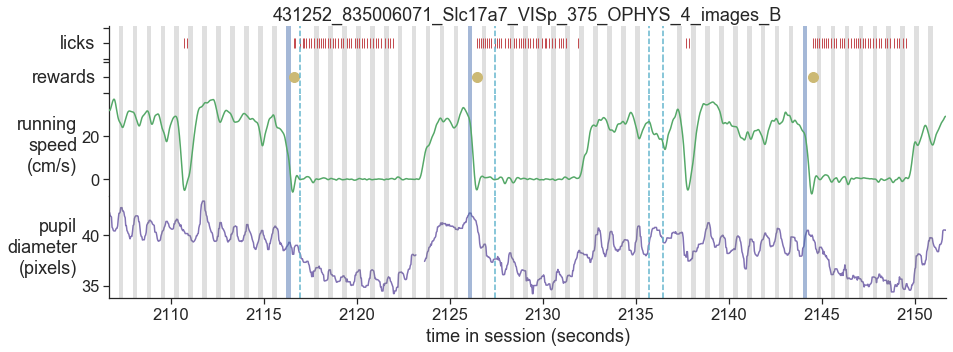

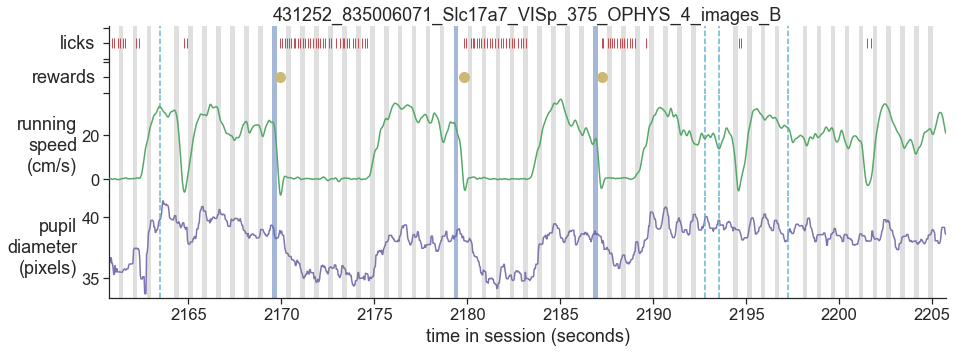

In [176]:
ophys_experiment_ids = [809501118, 808621034, 807753334, 835006071]

ophys_experiment_id = ophys_experiment_ids[3]

dataset = loading.get_ophys_dataset(ophys_experiment_id)

trials = dataset.trials.copy()
start_times = trials[trials.stimulus_change].start_time.values

for start_time in start_times[::4][:20]:
    ppf.plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20, save_dir=save_dir, ax=None)

### using VBA

In [ ]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [ ]:
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)

ophys_experiment_id = experiments_table.index.values[0]

dataset = loading.get_ophys_dataset(ophys_experiment_id)

trials = dataset.trials.copy()
start_times = trials[trials.stimulus_change].start_time.values
start_time = start_times[10]

ppf.plot_behavior_timeseries(dataset, start_time, duration_seconds=20, save_dir=save_dir, ax=None)

### performance plots

In [ ]:
dataset = loading.get_behavior_dataset(behavior_session_id, get_extended_trials=True)

### platform paper behavior session table

In [7]:
behavior_sessions = loading.get_platform_paper_behavior_session_table()

In [6]:
behavior_session_ids = utilities.get_behavior_session_ids_to_analyze()

In [8]:
behavior_session_id = behavior_session_ids[-1]

In [9]:
session = loading.get_behavior_dataset(behavior_session_id, get_extended_trials=True, get_extended_stimulus_presentations=True)

In [13]:
df = vbu.get_behavior_stats(behavior_session_id, engaged_only=True, method='trial_based')
df

{'behavior_session_id': 929836732,
 'response_latency_count': 70.0,
 'response_latency_mean': 0.5030309604414762,
 'response_latency_std': 0.14848779381571345,
 'response_latency_min': -0.021150000000034197,
 'response_latency_25%': 0.4625349730636117,
 'response_latency_50%': 0.5292362450422843,
 'response_latency_75%': 0.5751064633955139,
 'response_latency_max': 0.7294017687531777,
 'hit_rate': 0.6140350877192983,
 'fa_rate': 0.125,
 'number_of_engaged_go_trials': 114,
 'number_of_engaged_hits': 70,
 'number_of_engaged_catch_trials': 16,
 'number_of_engaged_false_alarms': 2,
 'fraction_engaged': 0.45774647887323944,
 'dprime_trial_corrected': 1.4402009095425108,
 'dprime_non_trial_corrected': 1.4402009095425108}

In [11]:
vbu.cache_behavior_stats(behavior_session_id)

### generate metrics

In [44]:
# from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
# cache_dir = loading.get_platform_analysis_cache_dir()
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
# session = cache.get_behavior_session(behavior_session_id)

In [42]:
behavior_session_id = experiments_table.behavior_session_id.values[10]

In [75]:
dataset = loading.get_behavior_dataset(behavior_session_id, get_extended_trials=True, 
                                       get_extended_stimulus_presentations=True)

In [83]:
vbu.get_behavior_stats(behavior_session_id, engaged_only=True, method='stimulus_based')

{'behavior_session_id': 794673280,
 'response_latency_count': 53.0,
 'response_latency_mean': 0.5120652830188601,
 'response_latency_std': 0.14014286503976228,
 'response_latency_min': 0.033360000000357104,
 'response_latency_25%': 0.4169999999999163,
 'response_latency_50%': 0.5337700000000041,
 'response_latency_75%': 0.6335500000000138,
 'response_latency_max': 0.7339400000000751,
 'hit_rate': 0.5196078431372549,
 'fa_rate': 0.4217687074829932,
 'number_of_engaged_go_trials': 102,
 'number_of_engaged_hits': 53,
 'number_of_engaged_catch_trials': 588,
 'number_of_engaged_false_alarms': 248,
 'fraction_engaged': 0.7348242811501597,
 'dprime_trial_corrected': 0.24654013228417762,
 'dprime_non_trial_corrected': 0.24654013228417762}

In [84]:
vbu.cache_behavior_stats(behavior_session_id)

In [87]:
dataset.get_performance_metrics()

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\scipy\stats\_distn_infrastructure.py:2017: RuntimeWarning:

invalid value encountered in greater

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\scipy\stats\_distn_infrastructure.py:2017: RuntimeWarning:

invalid value encountered in less



{'trial_count': 749,
 'go_trial_count': 144,
 'catch_trial_count': 22,
 'hit_trial_count': 69,
 'miss_trial_count': 75,
 'false_alarm_trial_count': 8,
 'correct_reject_trial_count': 14,
 'auto_reward_count': 0,
 'earned_reward_count': 69,
 'total_reward_count': 69,
 'total_reward_volume': 0.48300000000000004,
 'maximum_reward_rate': 2.7096551448241044,
 'engaged_trial_count': 79,
 'mean_hit_rate': 0.5124975082492916,
 'mean_hit_rate_uncorrected': 0.5193750182894523,
 'mean_hit_rate_engaged': 0.4653553739779136,
 'mean_false_alarm_rate': 0.3582963835681227,
 'mean_false_alarm_rate_uncorrected': 0.3438036299449343,
 'mean_false_alarm_rate_engaged': 0.29843304843304846,
 'mean_dprime': 0.3076599906029852,
 'mean_dprime_engaged': 0.4299229254591444,
 'max_dprime': 0.7288930421263174,
 'max_dprime_engaged': 0.7288930421263174}

In [85]:
df = vbu.get_cached_behavior_stats(behavior_session_id)

In [86]:
df

,behavior_session_id,response_latency_count,response_latency_mean,response_latency_std,response_latency_min,response_latency_25%,response_latency_50%,response_latency_75%,response_latency_max,hit_rate,fa_rate,number_of_engaged_go_trials,number_of_engaged_hits,number_of_engaged_catch_trials,number_of_engaged_false_alarms,fraction_engaged,dprime_trial_corrected,dprime_non_trial_corrected
0,794673280,53.0,0.512065,0.140143,0.03336,0.417,0.53377,0.63355,0.73394,0.519608,0.421769,102,53,588,248,0.734824,0.24654,0.24654


In [23]:
from visual_behavior_platform_paper.utilities import make_session_table

In [33]:
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

In [39]:
df = make_session_table.make_behavior_performance_table(experiments_table)

  1%|█▏                                                                                | 6/402 [00:00<00:39, 10.00it/s]

failed on 807356557 with error unsupported pickle protocol: 5


  4%|███▋                                                                             | 18/402 [00:00<00:21, 17.67it/s]

failed on 831824426 with error unsupported pickle protocol: 5


  6%|████▊                                                                            | 24/402 [00:01<00:17, 21.11it/s]

failed on 845441512 with error unsupported pickle protocol: 5


 25%|███████████████████▉                                                            | 100/402 [00:04<00:15, 19.97it/s]

failed on 1005032062 with error unsupported pickle protocol: 5


 30%|███████████████████████▉                                                        | 120/402 [00:05<00:13, 21.42it/s]

failed on 850976604 with error unsupported pickle protocol: 5
failed on 903708760 with error unsupported pickle protocol: 5


 31%|█████████████████████████                                                       | 126/402 [00:05<00:13, 19.93it/s]

failed on 991662910 with error unsupported pickle protocol: 5


 34%|███████████████████████████▍                                                    | 138/402 [00:06<00:11, 22.52it/s]

failed on 882256127 with error unsupported pickle protocol: 5


 41%|████████████████████████████████▍                                               | 163/402 [00:07<00:09, 24.33it/s]

failed on 1051129953 with error unsupported pickle protocol: 5
failed on 1051142682 with error unsupported pickle protocol: 5


 50%|████████████████████████████████████████▏                                       | 202/402 [00:08<00:08, 24.95it/s]

failed on 1076470023 with error File \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\behavior_perfomance_summary_stimulus_based\behavior_summary_behavior_session_id=1076470023.h5 does not exist
failed on 1076635241 with error File \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\behavior_perfomance_summary_stimulus_based\behavior_summary_behavior_session_id=1076635241.h5 does not exist
failed on 1078073756 with error File \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\behavior_perfomance_summary_stimulus_based\behavior_summary_behavior_session_id=1078073756.h5 does not exist
failed on 1076649660 with error File \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\behavior_perfomance_summary_stimulus_based\behavior_summary_behavior_session_id=1076649660.h5 does not exist
failed on 1077691596 with error File \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\behavior_perfomance_summary_stimulus_based\behavior_summary_behavior_sessi

In [40]:
df

,behavior_session_id,dprime_non_trial_corrected,dprime_trial_corrected,fa_rate,fraction_engaged,hit_rate,number_of_engaged_catch_trials,number_of_engaged_false_alarms,number_of_engaged_go_trials,number_of_engaged_hits,response_latency_25%,response_latency_50%,response_latency_75%,response_latency_count,response_latency_max,response_latency_mean,response_latency_min,response_latency_std
0,794968300,0.928048,0.928048,0.330233,0.809524,0.687500,430,142,80,55,0.483764,0.550455,0.633838,55.0,0.733919,0.531356,0.016651,0.149071
0,795742990,1.237250,1.237250,0.252046,0.530802,0.715385,611,154,130,93,0.450379,0.533754,0.633864,93.0,0.733948,0.499524,0.000000,0.184778
0,796251270,1.174287,1.174287,0.228571,0.878004,0.666667,770,176,180,120,0.433720,0.483762,0.604682,120.0,0.734298,0.507499,0.000000,0.132082
0,808324301,2.031932,2.031932,0.120941,0.973661,0.805556,893,108,216,174,0.366997,0.400315,0.417054,174.0,0.650543,0.398800,0.016680,0.072526
0,812955256,1.450932,1.450932,0.125641,0.613607,0.619318,780,98,176,109,0.366993,0.400333,0.450349,109.0,0.733941,0.404307,0.066692,0.092033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1067611874,1.362610,1.362610,0.150442,0.736280,0.628571,791,119,175,110,0.517248,0.567126,0.633795,110.0,0.734126,0.554246,0.016619,0.120265
0,1069251048,0.863163,0.863163,0.235862,0.605683,0.557047,725,171,149,83,0.500373,0.583862,0.675548,83.0,0.734053,0.549649,0.000000,0.186670
0,1066971490,0.888006,0.888006,0.141414,0.451024,0.426230,693,98,122,52,0.446195,0.517048,0.571310,52.0,0.733977,0.498176,0.150113,0.116471
0,1067619789,1.010597,1.010597,0.205882,0.984874,0.575269,986,203,186,107,0.533889,0.600535,0.683916,107.0,0.733965,0.585393,0.033314,0.135703


In [35]:
experiments_table.behavior_session_id

ophys_experiment_id
795073741      794968300
795953296      795742990
796308505      796251270
807752719      807356557
808619543      808324301
                 ...    
1086910722    1086389199
1087825602    1087699375
1086707480    1086170874
1086910729    1086389199
1087825608    1087699375
Name: behavior_session_id, Length: 402, dtype: int64

In [12]:
import visual_behavior_platform_paper.figure_1.make_performance_summary_panel as summary_panel

# summary_panel.get_performance_summary()

In [13]:
df = pd.read_csv(r"C:\Users\marinag\Documents\Code\visual_behavior_platform_paper\visual_behavior_platform_paper\assets\full_experiment_table.csv")

In [14]:
df

,version https://git-lfs.github.com/spec/v1
0,oid sha256:f3036128b9bfaccd13233627e9f72e2de07...
1,size 1285661


In [5]:

method = 'stimulus_based'
# def get_performance_summary(method='stimulus_based'):
session_dict = utilities.get_session_dict()

In [6]:
session_dict

{'TRAINING': 'last',
 'OPHYS_0': 'last',
 'OPHYS_1': 'all',
 'OPHYS_3': 'all',
 'OPHYS_4': 'all',
 'OPHYS_6': 'all'}

In [ ]:
experiment_table = utilities.load_table('full_experiment_table.csv')
experiment_table['date_of_acquisition'] = pd.to_datetime(experiment_table['date_of_acquisition'])

experiment_table['session_type_simple'] = (
    experiment_table['session_type']
    .map(lambda st: st.split('_')[0] + '_' + st.split('_')[1])
)

performance_df = pd.DataFrame()
for mouse_id in experiment_table.mouse_id.unique():
    for session_type in session_dict.keys():
        sessions = utilities.get_correct_sessions(
            experiment_table, 
            mouse_id,
            session_type,
            condition = session_dict[session_type]
            )
        if len(sessions) > 0:
            entry = {
                'mouse_id': mouse_id,
                'cre_line': sessions['cre_line'].unique()[0],
                'session_type': session_type,
                'dprime_trial_corrected': np.nanmedian(sessions['dprime_trial_corrected']),
                'reaction_time_mean': np.nanmedian(sessions['response_latency_mean']),
                'reaction_time_std': np.nanmedian(sessions['response_latency_std']),
            }
            performance_df = pd.concat((performance_df, pd.DataFrame(entry, index = [0])))

return performance_df